<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

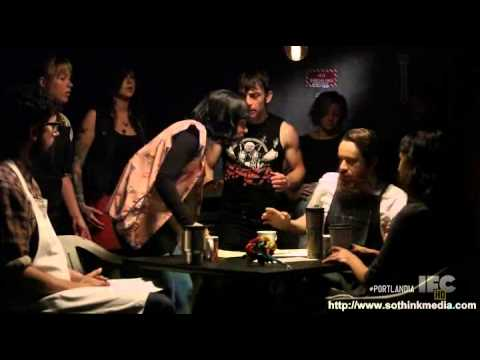

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\benjamin\\Desktop\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

Outline of Things to Do (Note to Self Do This First Else We go Down Rabbit Holes):

Exploratory Data Analysis

* Make Tokens Column and Squarify Plot DONE 
* Make Stop Worded Tokens Column and Squarify Plot DONE
* Extend Stop Words Column and Squarify Plot DONE
* Split dataframes into good reviews, bad reviews and do previous
* Write up results

Extra Things to Do

* Statistical Trimming of Extremely Rare Words
* Stemming/Lemma Worded Tokens Column and Squarify Plot
* Write up results


In [3]:
# Start here
import pandas as pd
import numpy as np
import spacy 
from spacy.tokenizer import Tokenizer
from collections import Counter
import seaborn as sns 

In [4]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"
shops = pd.read_csv(url)
shops.head(2)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating


In [5]:
shops.star_rating.value_counts()

 5.0 star rating     3780
 4.0 star rating     2360
 3.0 star rating      738
 2.0 star rating      460
 1.0 star rating      278
Name: star_rating, dtype: int64

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [6]:
# load language model
nlp = spacy.load("en_core_web_lg")

# Tokenizer instance
tokenizer = Tokenizer(nlp.vocab)

In [7]:
# try again on dummy sample
sample = "Is this the real life? Is this just fantasy? Caught in a landslide, no escape from reality."

# list comprehension
[token.text for token in tokenizer(sample)]

['Is',
 'this',
 'the',
 'real',
 'life?',
 'Is',
 'this',
 'just',
 'fantasy?',
 'Caught',
 'in',
 'a',
 'landslide,',
 'no',
 'escape',
 'from',
 'reality.']

# First Iteration of Tokenization

In [8]:
# try for our shop df

shop_tokens = []

# look up what batch size is later
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    # list comprehension nested inside for loop
    doc_tokens = [token.text for token in doc]
    shop_tokens.append(doc_tokens)
    
shops['tokens'] = shop_tokens


In [9]:
# should prob upload this helper function somewhere or find something close in docs

def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [10]:
# have to remove the dates
shops['tokens'].head(2)

0    [ , 11/25/2016, 1, check-in, Love, love, loved...
1    [ , 12/2/2016, Listed, in, Date, Night:, Austi...
Name: tokens, dtype: object

In [11]:
word_count_tokens = count(shops['tokens'])
word_count_tokens.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
7,the,6520,27779,1.0,0.034334,0.034334,0.856092
72,and,6804,25748,2.0,0.031824,0.066157,0.893382
50,,7616,22606,3.0,0.027940,0.094097,1.000000
37,a,6181,22085,4.0,0.027296,0.121394,0.811581
10,I,5469,19780,5.0,0.024447,0.145841,0.718093
52,to,5631,16904,6.0,0.020893,0.166734,0.739364
44,of,5087,12495,7.0,0.015443,0.182177,0.667936
98,is,4955,11748,8.0,0.014520,0.196697,0.650604
8,was,3743,9539,9.0,0.011790,0.208487,0.491465
87,in,4429,8901,10.0,0.011001,0.219488,0.581539


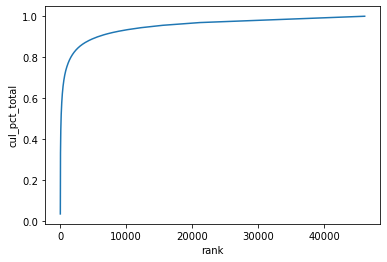

In [12]:
# distribution plot
sns.lineplot(x='rank', y='cul_pct_total', data=word_count_tokens);

As expected, these are mostly prepositions and stop words so let's fix that. Also for some reason, blank space is in the top 20 so we need to figure that one out. 

In [13]:
# put at top at the end

import squarify
import matplotlib.pyplot as plt

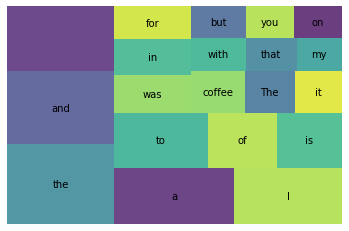

In [14]:
wct_top20 = word_count_tokens[word_count_tokens['rank'] <= 20]

squarify.plot(sizes=wct_top20['pct_total'], label=wct_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


# Default Stop Word Tokenization

In [15]:
len(nlp.Defaults.stop_words)

326

In [16]:
shop_stopped_tokens = []

# look up what batch size is later
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    # list comprehension nested inside for loop
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    
    shop_stopped_tokens.append(doc_tokens)
    
shops['stopped_tokens'] = shop_stopped_tokens

In [17]:
shops['stopped_tokens'].head(2)

0    [ , 11/25/2016, 1, check-in, love, love, loved...
1    [ , 12/2/2016, listed, date, night:, austin,, ...
Name: stopped_tokens, dtype: object

In [21]:
word_count_stopped_tokens = count(shops['stopped_tokens'])
word_count_stopped_tokens.head(30)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
14,,7616,22606,1.0,0.053592,0.053592,1.000000
45,coffee,4210,8058,2.0,0.019103,0.072695,0.552784
95,place,3029,4264,3.0,0.010109,0.082803,0.397715
119,great,2438,3250,4.0,0.007705,0.090508,0.320116
251,it's,2061,3117,5.0,0.007389,0.097897,0.270614
195,like,2034,2902,6.0,0.006880,0.104777,0.267069
192,good,2084,2779,7.0,0.006588,0.111365,0.273634
32,1,1998,2035,8.0,0.004824,0.116190,0.262342
42,check-in,1957,1961,9.0,0.004649,0.120839,0.256959
7,love,1434,1806,10.0,0.004281,0.125120,0.188288


In [19]:
wcst_top20 = word_count_stopped_tokens[word_count_stopped_tokens['rank'] <= 20]
wcst_top20.head(2)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
14,,7616,22606,1.0,0.053592,0.053592,1.000000
45,coffee,4210,8058,2.0,0.019103,0.072695,0.552784


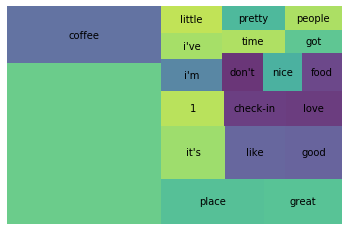

In [20]:
squarify.plot(sizes=wcst_top20['pct_total'], label=wcst_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [48]:
# Union 
STOP_WORDS = nlp.Defaults.stop_words.union([' ','-','coffee','1', 'got', 'place', 'time', 'check-in', "it's", "i've", "i'm", "don't",])


In [49]:
shop_extra_stopped_tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    shop_extra_stopped_tokens.append(doc_tokens)
    
shops['extra_stopped_tokens'] = shop_extra_stopped_tokens
   


In [50]:
shops['extra_stopped_tokens'].head(2)

0    [11/25/2016, love, love, loved, atmosphere!, c...
1    [12/2/2016, listed, date, night:, austin,, amb...
Name: extra_stopped_tokens, dtype: object

In [51]:
word_count_extra_stopped_tokens = count(shops['extra_stopped_tokens'])
word_count_extra_stopped_tokens.head(30)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
114,great,2438,3250,1.0,0.008680,0.008680,0.320116
190,like,2034,2902,2.0,0.007750,0.016430,0.267069
187,good,2084,2779,3.0,0.007422,0.023851,0.273634
7,love,1434,1806,4.0,0.004823,0.028675,0.188288
793,little,1230,1479,5.0,0.003950,0.032624,0.161502
160,nice,1188,1368,6.0,0.003653,0.036278,0.155987
447,food,1092,1363,7.0,0.003640,0.039918,0.143382
18,pretty,1066,1339,8.0,0.003576,0.043494,0.139968
963,people,1015,1223,9.0,0.003266,0.046760,0.133272
563,come,1031,1193,10.0,0.003186,0.049946,0.135373


In [52]:
wcst_top20 = word_count_extra_stopped_tokens[word_count_extra_stopped_tokens['rank'] <= 20]
wcst_top20.head(2)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
114,great,2438,3250,1.0,0.00868,0.00868,0.320116
190,like,2034,2902,2.0,0.00775,0.01643,0.267069


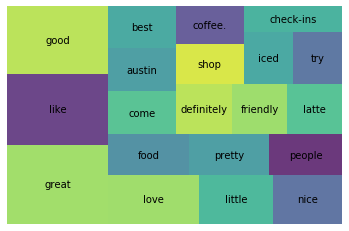

In [53]:
squarify.plot(sizes=wcst_top20['pct_total'], label=wcst_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

